# IVADO/Mila École d'apprentissage profond
# 4e édition (automne 2019)
# Tutoriel: Les données

## Auteurs: 

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

Francis Grégoire <francis.gregoire@mila.quebec>

## Traducteur:

Andrew Williams <andrew.williams@umontreal.ca>

# Préface

L'objectif de ce tutoriel est de souligner l'importance de comprendre les données sur lesquelles un projet d'apprentissage automatique (AA) est défini. Cette compréhension vous aidera à envisager les actions utiles à réaliser avant d'entraîner vos modèles d'apprentissage automatique. Ce tutoriel sert d'introduction douce à l'exploration des données et couvre les choses de base que tout praticien de l'apprentissage automatique devrait savoir.

**Note: le but de ce tutoriel est d'être une introduction. Ainsi, nous proposons des solutions simples à nos exercices. En pratique, vous devriez utiliser des techniques plus avancées pour entraîner vos modèles.**

# Introduction

Dans ce tutoriel, nous utiliserons l'ensemble de données [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10). Il s'agit d'une collection d'images en couleurs 32 x 32 réparties dans 10 classes différentes. Les 10 classes (indexées) différentes sont les suivantes :

0. avion ;
1. automobile ;
2. oiseau ;
3. chat ;
4. cerf ;
5. chien ;
6. grenouille ;
7. cheval ;
8. bateau ;
9. camion.

La tâche qui nous intéresse dans ce tutoriel est une tâche de classification d'images. C'est-à-dire que nous sommes intéressés à trouver, pour une image donnée, la classe à laquelle elle appartient. Nous utiliserons [PyTorch](https://pytorch.org/) comme cadre d'apprentissage automatique.

À ce stade, toutes les fonctions et les méthodes PyTorch connexes seront fournies et utilisées telles quelles. Ceci est parce que ce tutoriel n'est pas conçu pour apprendre PyTorch, mais plutôt pour se concentrer sur la compréhension des données et des concepts de base de l'apprentissage automatique. Dans les tutoriels suivants, vous apprendrez comment développer, entraîner et évaluer des modèles sur différents types de données.

# Téléchargement des données

Dans cette section, nous fournissons une fonction permettant de télécharger l'ensemble de données CIFAR-10. Elle prend en entrée deux arguments :
- **path** : répertoire dans lequel l'ensemble de données téléchargées sera sauvegardé.
- **train_flag** : indicateur booléen précisant s'il faut télécharger les données de l'ensemble d'entraînement (`train_flag=True`) ou de l'ensemble d'évaluation (`train_flag=False`).

Il retourne deux éléments:
- **imgs** : tableau numpy représentant les images téléchargées de taille N x 32 x 32 x 3 où N est le nombre d'images.
- **labels** : liste de N classes (indexées), chacune étant associée à une seule image.

## Attention: 
Plusieurs fonctionnalités de Python peuvent être retrouvés dans des bibliothèques qu'il faut installer et ensuite "importer" pour utiliser. Certaines fonctionnalités reliés à l'apprentissage automatique nous seront utiles. Il est donc important de les télécharger avant de commencer avec la cellule suivante (ceci peut prendre du temps, possiblement quelques minutes):

In [1]:
! pip install torch
! pip install torchvision

In [2]:
import torch
import torchvision


def download_CIFAR10(path, train_flag):
  """
  Args:
     path: répertoire dans lequel l'ensemble de données téléchargées sera sauvegardé.
     train_flag: si ''True'', télécharger les données de l'ensemble d'entraînement, sinon
        télécharger à partir de l'ensemble d'évaluation.
        
  Return:
     Un tuple de deux éléments (imgs, labels) où
        imgs : un tableau numpy de forme N x 32 x 32 x 3 où N est le nombre d'images.
        labels : liste de N classes (indexées), chacune étant associée à une seule image.
  
  """
  dataset = torchvision.datasets.CIFAR10(
      root=path, train=train_flag, download=True
  )
  imgs, labels = dataset.data, dataset.targets
  return imgs, labels


## Exercice

Téléchargez l'ensemble de données d'entraînement de CIFAR-10.

In [3]:
imgs, labels = download_CIFAR10('./', True)

Extracting ./cifar-10-python.tar.gz to ./


## Exercice

Téléchargez l'ensemble de données d'évaluation de CIFAR-10.

In [5]:
test_imgs, test_labels = download_CIFAR10('./', False)

Files already downloaded and verified


# ensemble de données de validation

Dans la section précédente, des fonctions ont été fournies pour télécharger les ensembles de données **d'entraînement** et **d'évaluation**. Comme vous l'avez appris dans ce cours, nous avons normalement besoin de trois ensembles de données dans un projet d'apprentissage automatique, à savoir les ensembles d'entraînement, de **validation** et d'évaluation. Malheureusement, l'ensemble de données CIFAR-10 ne contient pas d'ensemble de données de validation prétraitées natif, nous devons donc en **créer** un par échantillonnage à partir de l'ensemble de données **d'entraînement**.

Dans cette section, nous fournissons une fonction permettant de créer un ensemble de données de validation à partir de l'ensemble de données d'entraînement original. Elle prend en entrée cinq arguments :
- **imgs** : tableau numpy représentant l'ensemble d'images à partir duquel le partitionnement est effectué.
- **labels** : étiquettes associées à l'ensemble d'images fourni.
- **valid_ratio** (facultatif) : partie des données qui seront utilisées pour l'ensemble de validation. Valeur par défaut : `0.1`.
- **shuffle** ( facultatif ) : si les données doivent être mélangées ou non avant que le partitionnement ne soit effectué. Valeur par défaut : "True".
- **seed** ( facultatif ) : graine du générateur aléatoire. Valeur par défaut : `1234`.

Elle fournit en sortie 4 éléments, qui sont :
- **train_imgs** : tableau numpy représentant les images de l'ensemble d'entraînement après que le partitionnement soit fait.
- **train_labels** : étiquettes associées aux images de l'ensemble d'entraînement.
- **valid_imgs** : tableau numpy représentant les images de l'ensemble de validation après que le partitionnement soit fait.
- **valid_labels** : étiquettes associées aux images de l'ensemble de validation.

In [6]:
import numpy as np


def partition_dataset(imgs, labels, valid_ratio=0.1, shuffle=True, seed=1234):
  """
  Args:
     imgs: tableau numpy représentant l'ensemble d'images à partir duquel 
        le partitionnement est fait.
     labels: les étiquettes associées aux images fournies.
     valid_ratio (facultatif) : la partie des données qui sera utilisée dans
        le jeu de validation. Valeur par défaut : 0.1.
     shuffle (facultatif) : permet de mélanger ou non les données. Par défaut : True.
     seed (facultatif) : la graine du générateur aléatoire numpy : Valeur par défaut : 1234.
        
  Return (retour):
     Un tuple de 4 éléments (train_imgs, train_labels, valid_imgs, valid_labels)
     où :
        train_imgs : un tableau numpy d'images pour l'ensemble d'entraînement.
        train_labels : étiquettes associées aux images de l'ensemble d'entraînement.
        valid_imgs : un tableau numpy d'images pour l'ensemble de validation.
        valid_labels : étiquettes associées aux images de l'ensemble de validation.

  """
  if shuffle:
    np.random.seed(seed)  # Fixer la graine aléatoire de numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  
  train_idx, valid_idx = np.split(
      indices, 
      [int((1.0 - valid_ratio)*len(indices))]
  )
  train_imgs, valid_imgs = imgs[train_idx], imgs[valid_idx]
  tgt = np.array(labels)
  train_labels, valid_labels = tgt[train_idx].tolist(), tgt[valid_idx].tolist()
  return train_imgs, train_labels, valid_imgs, valid_labels
  

## Exercice

En utilisant les paramètres par défaut, générer les ensembles de données d'entraînement et de validation.

In [7]:
train_imgs, train_labels, valid_imgs, valid_labels = partition_dataset(imgs, labels)

# Visualisation de données

C'est toujours une bonne pratique de visualiser les données avec lesquelles nous travaillons. En particulier, la visualisation de la distribution des données fournira des indications précieuses sur les données en question.

Dans cette section, nous fournissons quelques fonctions permettant de visualiser les données d'images et de calculer la distribution des étiquettes au sein d'un ensemble de données.

In [9]:
import matplotlib.pyplot as plt


def plot_image(image):
  """
  Tracer une seule image.
  
  Args :
     image : image à tracer.
     
  """
  plt.imshow(image)
  plt.show()

  
def plot_random_images_from_dataset(images, n):  
  """
  Échantillonner au hasard n images d'un ensemble d'images et les tracer dans une grille.
  
  Args :
     images: collection d'images à partir desquelles l'échantillonnage sera effectué.
     n: le nombre d'images à échantillonner.
     
  """
  sampled_indices = np.random.choice(images.shape[0], n, False)
  sampled_images = images[sampled_indices]
  
  sampled_images = np.transpose(sampled_images, (0, 3, 1, 2))
  sampled_tensor = torch.Tensor(sampled_images)
  
  grid_tensor = torchvision.utils.make_grid(
      sampled_tensor, normalize=True, range=(0, 255)
  )
  grid_tensor = np.transpose(grid_tensor.numpy(), (1, 2, 0))
  
  plot_image(grid_tensor)
  
  
def plot_dataset_histogram(labels, title="Distribution d'étiquettes"):
  """
  Tracez l'histogramme/la distribution des étiquettes dans un ensemble de données.
  
  Args :
     labels : collection d'étiquettes à partir desquelles la distribution est calculée.
     
  """
  _ = plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.85)
  plt.title(title)
  plt.xlabel('Étiquette')
  plt.ylabel('Fréquence')
  plt.xticks(np.arange(10))
  plt.show()


## Exercice

Utilisez les fonctions définies précédemment pour visualiser des échantillons provenant d'ensembles de données d'entraînement et de validation. Calculez également la distribution des étiquettes dans ces deux ensembles de données. Quelles conclusions pouvez-vous en tirer?

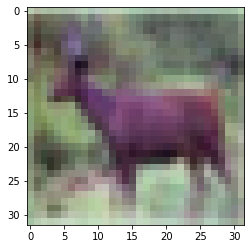

Étiquette: 4


In [11]:
# tracer un échantillon donné à partir de l'ensemble des données d'entraînement et récupérer son étiquette
i = 15
plot_image(train_imgs[i])
print('Étiquette: {}'.format(train_labels[i]))  # 4 = deer.


Comme on peut le voir, la bonne étiquette est attribuée à la bonne image. C'est une bonne pratique de vérifier que les index des images et des étiquettes sont alignés.

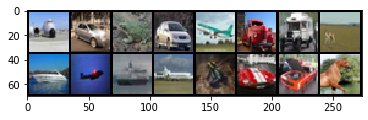

In [12]:
# tracer des échantillons aléatoires (par exemple, 16) à partir de l'ensemble des données d'entraînement
plot_random_images_from_dataset(train_imgs, 16)


On peut observer qu'il existe différents modèles de voitures. De plus, les angles sous lesquels les photos ont été prises sont différents. Il en va de même pour les couleurs de fond qui sont diverses. De plus, un arrière-plan donné est partagé entre différentes classes (pas de corrélation trompeuse). On observe également que la plupart des objets sont centrés, ce qui facilite la tâche de classification.


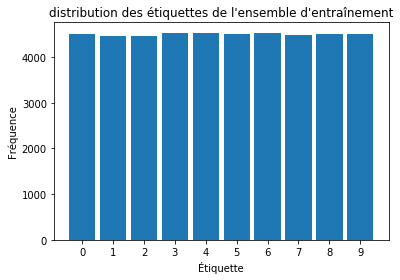

In [13]:
# tracer la distribution des étiquettes de l'ensemble des données d'entraînement
plot_dataset_histogram(train_labels, "distribution des étiquettes de l'ensemble d'entraînement")


La distribution des étiquettes de l'ensemble de données d'entraînement CIFAR-10 original est parfaitement équilibrée (où chaque classe compte 5000 exemples). Ainsi, le brassage et la division des données en partitions conduiront à des ensembles de données où toutes les partitions auront une distribution (presque) uniforme. D'autre part, lorsque les étiquettes de l'ensemble de données d'origine sont déséquilibrées, ce qui est généralement le cas dans les problèmes de classification du monde réel, mélanger et de diviser naïvement l'ensemble de données pourrait entraîner un problème majeur : des classes peu fréquentes se retrouvent dans une partition et pas dans l'autre. Dans un tel cas, il est recommandé d'utiliser des techniques d'échantillonnage avancées, telles que [l'échantillonnage stratifié](https://en.wikipedia.org/wiki/Stratified_sampling). Plus loin dans ce tutoriel, nous montrons comment utiliser la pondération préférentielle.


# Mélanger les données

Lorsque vous créez vos propres ensembles d'entraînement, de validation et d'évaluation, il est essentiel de **mélanger** l'ensemble de données d'origine pour répartir les données entre les ensembles d'entraînement, de validation et d'évaluation afin de s'assurer qu'elles sont plus représentatives de la **distribution globale des données**. Le brassage de votre ensemble de données réduira également les biais si vos données proviennent de sources différentes.

Les ensembles de données CIFAR-10 téléchargés au début de ce tutoriel ont déjà été mélangés. Pour visualiser l'efficacité du brassage, supposons que vous receviez un ensemble de données et qu'après la division, vous observiez les distributions d'étiquettes suivantes.

Quelles seront les conséquences de l'utilisation de ce fractionnement sur vos mesures de performance ?

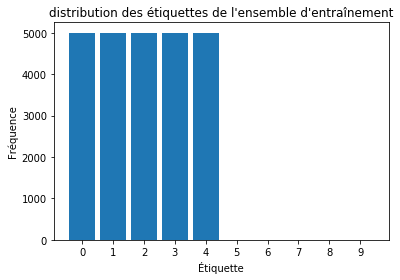

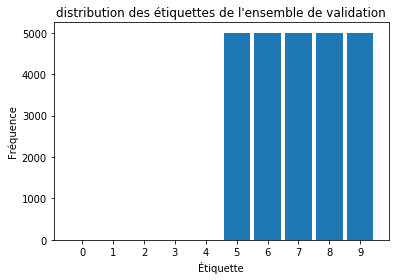

In [14]:
sorted_idx = np.argsort(labels)
sorted_imgs = imgs[sorted_idx]
sorted_labels = [labels[i] for i in sorted_idx]

_, sorted_train_labels, _, sorted_valid_labels = partition_dataset(sorted_imgs, sorted_labels,
                                                                   valid_ratio=0.5, shuffle=False)
plot_dataset_histogram(sorted_train_labels, "distribution des étiquettes de l'ensemble d'entraînement")
plot_dataset_histogram(sorted_valid_labels, "distribution des étiquettes de l'ensemble de validation")

Les mesures de performance seront bonnes sur l'ensemble d'entraînement, mais terribles sur l'ensemble de validation car le modèle est évalué sur des exemples avec des étiquettes qu'il n'a jamais vues pendant l'entraînement. Comme l'ensemble de validation est utilisé pour évaluer et ajuster notre modèle pendant l'entraînement, il sera inutile dans ce cas. Idéalement, nous voulons un classificateur qui n'est pas biaisé en faveur d'une ou de quelques classes.


Ci-dessous, nous mélangeons les données et observons que les étiquettes sont uniformément réparties dans les ensembles d'entraînement/validation, ce qui est une propriété nécessaire pour effectuer un réglage d'hyperparamètres précis sur un ensemble de validation.

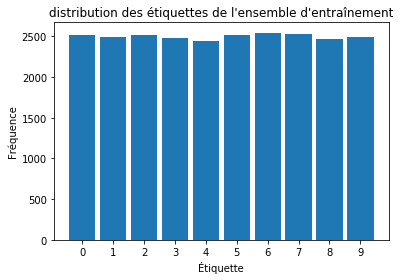

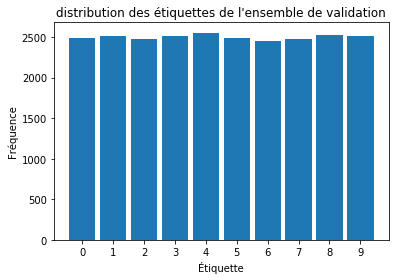

In [15]:
_, shuffled_train_labels, _, shuffled_valid_labels = partition_dataset(
    sorted_imgs, sorted_labels, valid_ratio=0.5, shuffle=True
)

plot_dataset_histogram(shuffled_train_labels, "distribution des étiquettes de l'ensemble d'entraînement")
plot_dataset_histogram(shuffled_valid_labels, "distribution des étiquettes de l'ensemble de validation")

# Lecteurs de données

Comme vous le verrez dans les prochains tutoriels, pour entraîner et évaluer les modèles d'apprentissage automatique, nous utilisons des **lecteurs de données (*data loaders*)**. Comme l'apprentissage automatique nécessite une utilisation intensive de la transformation des données, nous voulons des outils qui **transforment**, **mélangent** et **partitionnent** efficacement nos ensembles de données avec la possibilité d'utiliser des travailleurs multiprocesseurs. Un lecteur de données est un itérateur de données optimisé qui offre toutes ces fonctionnalités.

Il y a quelques années, pour entraîner un modèle d'apprentissage profond sur une tâche donnée, nous avions besoin de coder notre propre lecteur de données. Heureusement, les cadres modernes d'apprentissage profond, tels que PyTorch et TensorFlow, ont introduit des lecteurs de données très efficaces dans leurs dernières versions.

## Exercice
Nous présentons un exemple simple de préparation d'un lecteur de données à l'aide d'un petit sous-ensemble de notre ensemble d'entraînement. Pendant l'entraînement, la meilleure pratique consiste à mélanger les données au début de chaque **époque** (chaque répétition sur un ensemble de données entier est généralement appelée une époque). Ainsi, nous définissons normalement "shuffle=True" pour l'entraînement et "shuffle=False" pour l'évaluation.

In [16]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader


def create_dataset(images, labels, n):
  """
  Sélectionner les n premières images/étiquettes et créez un torch.utils.data.DataLoader.
  
  Args :
     images : tableau numpy d'images.
     labels : liste des étiquettes associées aux images.
     n : le nombre d'images/étiquettes à sélectionner.
        
  Return (Retour) :
     Un jeu de données du tenseur torch.utils.data.TensorDataset 
         à utiliser avec un torch.utils.data.DataLoader.
     
  """
  imgs = torch.tensor(images[:n], dtype=torch.float)
  labels = torch.tensor(labels[:n], dtype=torch.long)
  dataset = TensorDataset(imgs, labels)
  return dataset


n = 100
batch_size = 32
train_dataset = create_dataset(train_imgs, train_labels, n)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

epochs = 2
for epoch in range(epochs):
  print('Époque {}/{}:'.format(epoch+1, epochs))
  for i, (x, y) in enumerate(train_dataloader):
    print('   batch {}/{} de {} exemples.'.format(i+1, int(np.ceil(n/batch_size)), y.size(0)))

Époque 1/2:
   batch 1/4 de 32 exemples.
   batch 2/4 de 32 exemples.
   batch 3/4 de 32 exemples.
   batch 4/4 de 4 exemples.
Époque 2/2:
   batch 1/4 de 32 exemples.
   batch 2/4 de 32 exemples.
   batch 3/4 de 32 exemples.
   batch 4/4 de 4 exemples.


Nous voyons que nous pouvons facilement itérer sur l'ensemble de données créé pour un certain nombre d'époques avec une simple boucle `for`. A chaque itération, le lecteur de données retourne un mini lot de paires d'étiquettes d'entrée `(x, y)` de taille `batch_size`.

En réglant `drop_last=False`, le dernier lot incomplet est conservé si la taille de l'ensemble de données n'est pas divisible par `batch_size`. Lors de l'entraînement d'un modèle, pour calculer la perte, nous faisons normalement la moyenne des pertes des exemples d'un mini lot. Ainsi, en ayant un mini lot de 4 exemples au lieu de 32, les exemples du dernier mini lot ont plus d'importance que les autres exemples de l'ensemble de données. En pratique, cela n'est pas préjudiciable car les exemples sont mélangés au début d'une époque. Par conséquent, à chaque époque, nous devrions avoir des exemples différents dans le dernier mini lot. Plus de détails sur ce sujet seront fournis dans les prochains jours.


# L'entraînement avec les réseaux de neurones

Dans cette section, nous fournissons des méthodes basées sur les réseaux de neurones qui seront utilisées par la suite comme des boîtes noires à des fins d'entraînement et d'évaluation. Ne vous inquiétez pas, dans les prochains tutoriels, vous apprendrez comment écrire de tels morceaux de code.

Deux méthodes seront utilisées de manière intensive dans les sections suivantes. 

La première est la `training_on_dataset`, qui consiste à entraîner un modèle sur un ensemble de données donné. Elle prend en entrée les arguments suivants et retourne un **modèle entraîné** :
- **imgs** : images sur lesquelles le modèle sera entraîné.
- **labels** : étiquettes associées aux images fournies.
- **eval_imgs** : images pour évaluer le modèle.
- **eval_labels** : étiquettes associées aux images utilisées pour évaluer le modèle.
- **epochs** : nombre d'époques pendant l'entraînement (nombre de fois à boucler sur l'ensemble des images/étiquettes).
- **batch_size** (facultatif) : taille d'un mini-lot. Par défaut : `8`.
- **lr** ( facultatif ) : taux d'apprentissage. Valeur par défaut : `1e-3`.
- **seed** ( facultatif) : graine du générateur aléatoire. Valeur par défaut : `1234`.
- **transformations** ( facultatif ) : transformations à appliquer sur les images pendant le processus d'entraînement. Valeur par défaut : `None`.
- **label_weights** ( facultatif ) : poids d'importance associés à chaque étiquette. Valeur par défaut : `None` (tous les étiquettes sont traitées de la même manière).
- **metrics** (facultatif) : métriques à surveiller pendant l'entraînement. Valeur par défaut : `None`.


Dans cette section, nous fournissons des méthodes basées sur les réseaux de neurones qui seront utilisées par la suite comme des boîtes noires à des fins d'entraînement et d'évaluation. Ne vous inquiétez pas, dans les prochains tutoriels, vous apprendrez comment écrire de tels morceaux de code.

Deux méthodes seront utilisées de manière intensive dans les sections suivantes. 

La première est la `training_on_dataset`, qui consiste à entraîner un modèle sur un ensemble de données donné. Elle prend en entrée les arguments suivants et retourne un **modèle entraîné** :
- **imgs** : images sur lesquelles le modèle sera entraîné.
- **labels** : étiquettes associées aux images fournies.
- **eval_imgs** : images pour évaluer le modèle.
- **eval_labels** : étiquettes associées aux images utilisées pour évaluer le modèle.
- **epochs** : nombre d'époques pendant l'entraînement (nombre de fois à boucler sur l'ensemble des images/étiquettes).
- **batch_size** (facultatif) : taille d'un mini-lot. Par défaut : `8`.
- **lr** ( facultatif ) : taux d'apprentissage. Valeur par défaut : `1e-3`.
- **seed** ( facultatif) : graine du générateur aléatoire. Valeur par défaut : `1234`.
- **transformations** ( facultatif ) : transformations à appliquer sur les images pendant le processus d'entraînement. Valeur par défaut : `None`.
- **label_weights** ( facultatif ) : poids d'importance associés à chaque étiquette. Valeur par défaut : `None` (tous les étiquettes sont traitées de la même manière).
- **metrics** (facultatif) : métriques à surveiller pendant l'entraînement. Valeur par défaut : `None`.


La deuxième est `evaluate_classes`, qui évalue un modèle entraîné sur un ensemble de données donné. Elle prend en entrée les arguments suivants et retourne la **performance d'évaluation** :
- **net** : le modèle entraîné à évaluer.
- **imgs** : images sur lesquelles le modèle sera évalué.
- **labels** : étiquettes de vérité fondamentale associées aux images fournies pour le calcul des performances.
- **batch_size** ( facultatif ) : taille d'un mini-lot. Valeur par défaut : `8`.
- **metrics** ( facultatif ) : mesures de performance à calculer. Valeur par défaut : `None`.





In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classe_names = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
)


def accuracy(y_true, y_pred):
  """
  Calculer le score d'exactitude.
  
  Args :
     y_true : étiquettes de vérité de base.
     y_pred : étiquettes prédites par un classificateur.
     
  Return (Retour) :
     Score d'exactitude.     
  """
  return metrics.accuracy_score(y_true, y_pred)


def f1_score(y_true, y_pred):
  """
  Calculer le score F1.
  
  Args :
     y_true : étiquettes de vérité de base.
     y_pred : étiquettes prédites par un classificateur.
     
  Return (Retour) :
     Score F1.
     
  """
  return metrics.f1_score(y_true, y_pred, average='macro')


def plot_metric(train_values, valid_values, name=''):
  """
  Tracer les valeurs d'une mesure de performance fournie sur des ensembles d'entraînement et de validation.
  
  Args :
     train_values : valeurs de la mesure sur l'ensemble d'entraînement. 
     valid_values : valeurs de la mesure sur l'ensemble de validation.
     name : nom de la mesure.
  """
  x = range(len(train_values))
  plt.plot(x, train_values, label='Entraînement')
  plt.plot(x, valid_values, label='Validation')
  plt.title(name)
  plt.legend()
  plt.show()
  

class AugmentBasedDataset(Dataset):
  """Ensemble de données encapsulé pour l'augmentation des données."""

  def __init__(self, dataset, transform=None):
    """
    Args :
        ensemble de données : ensemble de données sur lequel on veut effectuer 
            une augmentation de données.
        transform (exécutable, facultatif) : transformation facultative à 
            appliquer sur un échantillon.
    """
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img, label = self.dataset[idx]
    if self.transform:
        img = self.transform(img)
    return img, label


In [18]:
class Net(nn.Module):
  """CNN de base utilisé pour la classification des images."""
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [19]:
def training_on_dataset(imgs, labels, eval_imgs, eval_labels,
                        epochs, batch_size=8, lr=1e-3,
                        seed=1234, transformations=None, label_weights=None,
                        metrics=None, verbose=True):
  """
  Fonction boîte noire pour entraîner un réseau de neurones 
  sur le jeu de données CIFAR-10.
  """
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  
  # Données d'entraînement.
  train_imgs = ((imgs/255.0) - 0.5) * 2.0  # Normaliser à [-1, 1].
  train_imgs = np.transpose(train_imgs, (0, 3, 1, 2))
  train_labels = np.array(labels)
  
  train_dataset = TensorDataset(
      torch.from_numpy(train_imgs).float(), 
      torch.from_numpy(train_labels).long()
  )
  train_dataset = AugmentBasedDataset(train_dataset, transformations)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Données d'évaluation.
  eval_imgs = ((eval_imgs/255.0) - 0.5) * 2.0 # Normaliser à [-1, 1].
  eval_imgs = np.transpose(eval_imgs, (0, 3, 1, 2))
  eval_labels = np.array(eval_labels)
  
  eval_dataset = TensorDataset(
      torch.from_numpy(eval_imgs).float(), 
      torch.from_numpy(eval_labels).long()
  )
  eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

  net = Net()
  net = net.to(device)
  if label_weights is not None:
    label_weights = torch.tensor(label_weights).float()
    label_weights = label_weights.to(device)
  criterion = nn.CrossEntropyLoss(weight=label_weights)
  optimizer = optim.Adam(net.parameters(), lr=lr)
  
  train_loss_values = []
  eval_loss_values = []
  train_metric_values = None
  eval_metric_values = None
  
  if metrics is not None:
    if isinstance(metrics, dict):
      train_metric_values = {metric: [] for metric in metrics.keys()}
      eval_metric_values = {metric: [] for metric in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}
    else:
      metrics = [metrics]
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}

  for epoch in range(epochs):  # Passer en boucle sur l'ensemble des données.
    net.train()
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
    for data in train_dataloader:
      # Les données sont un tuple de (entrées, cibles).
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
      
      inputs = inputs.to(device)
      targets = targets.to(device)       

      # Réinitialiser les gradients des paramètres.
      optimizer.zero_grad()

      # Propagation avant + propagation arrière + optimiser.
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      # Prédire l'étiquette.
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())

      running_loss += loss.item()
      n_update += 1

    # Sauvegarder et imprimer les statistiques à la fin de chaque époque d'entraînement.
    train_loss = running_loss / n_update
    train_loss_values.append(train_loss)
    eval_loss, eval_true, eval_pred = evaluate_during_training(net, criterion, eval_dataloader)
    eval_loss_values.append(eval_loss)
    
    if metrics is not None:
      for metric in metrics.keys():
        train_metric_values[metric].append(metrics[metric](y_true, y_pred))
        eval_metric_values[metric].append(metrics[metric](eval_true, eval_pred))
  
    if verbose:
      print("[Époque {}/{}] Perte d'entraînement: {:.3f} | Perte de validation: {:.3f}" 
            .format(epoch + 1, epochs, train_loss, eval_loss)
      )
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
  
  if verbose:
    plot_metric(train_loss_values, eval_loss_values, 'Perte')
    if metrics is not None:
      for metric in metrics.keys():
        plot_metric(train_metric_values[metric], eval_metric_values[metric], metric)
  
  return net


def evaluate_during_training(net, criterion, dataloader):
  net.eval()
  running_loss = 0.0
  n_update = 0
  y_true = []
  y_pred = []
  for data in dataloader:
    inputs, targets = data
    if targets.numel() > 1:
      y_true.extend(targets.flatten().tolist())
    else:
      y_true.append(targets.flatten().tolist())
    inputs = inputs.to(device)
    targets = targets.to(device) 
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, targets)  
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      running_loss += loss.item()
      n_update += 1
  eval_loss = running_loss / n_update
  return eval_loss, y_true, y_pred


def evaluate_classes(net, imgs, labels, batch_size=8, metrics=None, verbose=True):
  """
  Fonction boîte noire pour évaluer un réseau de neurones sur un ensemble de 
      données CIFAR-10.
  """
  normalized_imgs = ((imgs/255.0) - 0.5) * 2.0 # Normaliser à [-1, 1].
  normalized_imgs = np.transpose(normalized_imgs, (0, 3, 1, 2))
  arr_labels = np.array(labels)
  
  dataset = TensorDataset(
      torch.from_numpy(normalized_imgs).float(), 
      torch.from_numpy(arr_labels).long()
  )
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
  
  net = net.to(device)
  correct = 0
  total = 0
  class_correct = [0.0] * 10
  class_total = [0.0] * 10
  class_acc = [0.0] * 10
  
  metric_values = None
  if not (metrics is None):
    if isinstance(metrics, dict):
      metric_values = {a: 0.0 for a in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      metric_values = {a: 0.0 for a in range(len(metrics))}
    else:
      metrics = [metrics]
      metric_values = {a: 0.0 for a in range(len(metrics))}
  
  with torch.no_grad():
    y_true = []
    y_pred = []
    for data in dataloader:
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
        
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      
      if predicted.numel()>1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      
      total += targets.size(0)
      correct += (predicted == targets).sum().item()
      
      c = (predicted == targets).squeeze()
      for i in range(targets.size(0)):
        label = targets[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
            
    if not (metric_values is None):
      for a in metric_values.keys():
        metric_values[a] = metrics[a](y_true, y_pred)
            
  global_acc = correct / max(total, 1.0)
  
  if verbose:
    if metrics is not None:
      print("Évaluation sur l'ensemble des données de validation: ")
      for a in metric_values.keys():
        print('Mesure {}: {:.0%}'.format(a, metric_values[a]))

  for i in range(10):
    class_acc[i] = class_correct[i] / max(class_total[i], 1.0)
    if verbose:
      print('Exactitude de {:<5s} ({}): {:.0%}'
            .format(classe_names[i], i, class_acc[i])
           )
    
  return global_acc, class_acc


# Quelle est la quantité de données nécessaires à l'entraînement ?



Dans cette section, nous étudions l'effet de la taille des données d'entraînement sur la performance finale de la tâche considérée. Nous explorons également une technique, appelée **augmentation des données**, pour augmenter artificiellement la taille d'un ensemble de données donné pendant le processus d'entraînement.

Notez que nous gardons l'ensemble de données de validation fixe tout au long de ce tutoriel. C'est juste pour le but de ce tutoriel, car nous voulons que les différentes évaluations soient comparables. Dans les scénarios de la vie réelle, l'ensemble de données de validation ne doit jamais être plus grand que l'ensemble de données d'entraînement.

## Entraînement avec seulement 1% des données

Commençons par considérer seulement 1% de nos données d'entraînement. La méthode suivante permet de sélectionner une partie des données d'un ensemble de données donné. Elle prend en entrée cinq arguments :
- **imgs** : tableau numérique représentant l'ensemble d'images à partir duquel la sélection est effectuée.
- **labels** : étiquettes associées à l'ensemble d'images fourni.
- **ratio** (facultatif) : partie des données qui seront sélectionnées. Valeur par défaut : `0.1`.
- **shuffle** ( facultatif ) : si les données doivent être mélangées ou non avant que la sélection ne soit effectuée. Valeur par défaut : `True`.
- **seed** ( facultatif ) : graine du générateur aléatoire : Valeur par défaut : `1234`.

Elle fournit en sortie 2 éléments :
- **select_imgs** : tableau numpy des images sélectionnées.
- **select_labels** : étiquettes associées aux images sélectionnées.


In [20]:
def select_subset_from_dataset(imgs, labels, ratio=0.1, shuffle=True, seed=1234):
  """
  Args:
  Args :
     imgs : tableau numpy représentant l'ensemble d'images à partir duquel 
        la sélection est faite.
     labels : les étiquettes associées aux images fournies.
     ratio (facultatif) : partie des données à sélectionner. 
         Par défaut : 0,1.
     shuffle (facultatif) : Permet de mélanger ou non les données. 
         Par défaut : True.
     seed (facultatif) : semence du générateur aléatoire numpy. 
         Par défaut : 1234.
        
  Return (retour) :
     Un tuple de 2 éléments (select_imgs, select_labels)
     où :
        select_imgs : un tableau numpy des images sélectionnées.
        select_labels : étiquettes associées aux images sélectionnées.
      
  """
  if shuffle:
    np.random.seed(seed)  # Fixez la graine aléatoire de numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  idx, _ = np.split(indices, [int(ratio*len(indices))])
  select_imgs = imgs[idx]
  tgt = np.array(labels)
  select_labels = tgt[idx].tolist()
  return select_imgs, select_labels


select_imgs, select_labels = select_subset_from_dataset(
    train_imgs, train_labels, 0.01
)

### Exercice

Entraînez un modèle en utilisant les données sélectionnées et évaluez sa performance sur l'ensemble de données de validation. Les arguments suivants doivent être utilisés :
- **epochs** : `5`.
- **batch_size** : `32`.
- **metrics** : `{'Exactitude' : accuracy}`.

Qu'observez-vous ?

[Époque 1/5] Perte d'entraînement: 2.287 | Perte de validation: 2.269
[Époque 2/5] Perte d'entraînement: 2.220 | Perte de validation: 2.206
[Époque 3/5] Perte d'entraînement: 2.117 | Perte de validation: 2.158
[Époque 4/5] Perte d'entraînement: 2.034 | Perte de validation: 2.116
[Époque 5/5] Perte d'entraînement: 1.997 | Perte de validation: 2.121


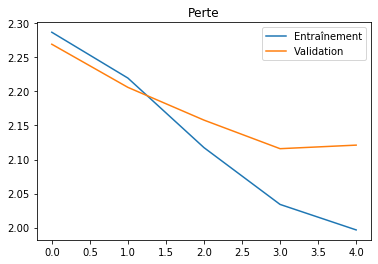

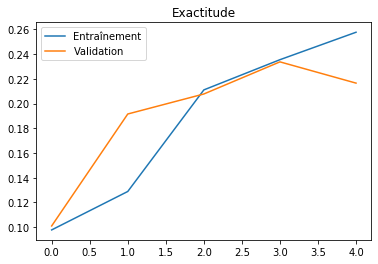

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 22%
Exactitude de plane (0): 53%
Exactitude de car   (1): 37%
Exactitude de bird  (2): 1%
Exactitude de cat   (3): 9%
Exactitude de deer  (4): 0%
Exactitude de dog   (5): 3%
Exactitude de frog  (6): 86%
Exactitude de horse (7): 0%
Exactitude de ship  (8): 9%
Exactitude de truck (9): 20%


In [22]:
# Entraîner sur les données sélectionnées
model = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=5, batch_size=32, metrics={'Exactitude': accuracy})

# Évaluer le modèle entraîné sur l'ensemble de validation
_ = evaluate_classes(model, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude': accuracy})

Nous observons que la performance sur l'ensemble des données de validation est de 22 %, ce qui est relativement proche de celle obtenue sur l'ensemble d'entraînement (27,5 %). De plus, en examinant les pertes d'entraînement et de validation, nous constatons que le processus d'entraînement a peut-être été interrompu trop rapidement car le modèle pourrait encore converger vers de meilleures solutions. Dans le prochain exercice, nous laisserons l'entraînement se dérouler sur des périodes plus longues et nous observerons ce qui se passe.


### Exercice
Dans l'exercice précédent, nous avons limité le nombre d'époques à "5". Dans cette section, nous vous demandons d'entraîner votre modèle en utilisant un nombre d'époques plus élevé (par exemple, `50`, `100`). Pour une comparaison équitable, vous devez conserver les arguments suivants :
- **batch_size**: `32`.
- **metrics**: `{'Exactitude': accuracy}`.
- **eval_imgs**: `valid_imgs`.
- **eval_labels**: `eval_labels`.

Qu'observez-vous ?


[Époque 1/50] Perte d'entraînement: 2.287 | Perte de validation: 2.269
[Époque 2/50] Perte d'entraînement: 2.220 | Perte de validation: 2.206
[Époque 3/50] Perte d'entraînement: 2.117 | Perte de validation: 2.158
[Époque 4/50] Perte d'entraînement: 2.034 | Perte de validation: 2.116
[Époque 5/50] Perte d'entraînement: 1.997 | Perte de validation: 2.121
[Époque 6/50] Perte d'entraînement: 1.915 | Perte de validation: 2.061
[Époque 7/50] Perte d'entraînement: 1.872 | Perte de validation: 2.034
[Époque 8/50] Perte d'entraînement: 1.819 | Perte de validation: 2.048
[Époque 9/50] Perte d'entraînement: 1.746 | Perte de validation: 2.048
[Époque 10/50] Perte d'entraînement: 1.674 | Perte de validation: 2.068
[Époque 11/50] Perte d'entraînement: 1.594 | Perte de validation: 2.159
[Époque 12/50] Perte d'entraînement: 1.610 | Perte de validation: 2.097
[Époque 13/50] Perte d'entraînement: 1.598 | Perte de validation: 2.153
[Époque 14/50] Perte d'entraînement: 1.563 | Perte de validation: 2.030
[

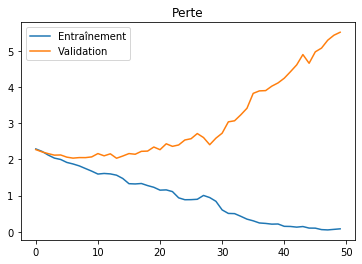

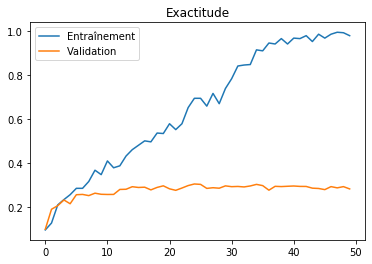

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 28%
Exactitude de plane (0): 40%
Exactitude de car   (1): 35%
Exactitude de bird  (2): 25%
Exactitude de cat   (3): 20%
Exactitude de deer  (4): 15%
Exactitude de dog   (5): 22%
Exactitude de frog  (6): 48%
Exactitude de horse (7): 19%
Exactitude de ship  (8): 37%
Exactitude de truck (9): 23%


In [23]:
# Entraîner sur les données sélectionnées
model = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=50, batch_size=32, metrics={'Exactitude': accuracy})

# Évaluer le modèle entraîné sur l'ensemble de validation
_ = evaluate_classes(model, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude': accuracy})


Après la 8e époque, on commence à observer une augmentation de la divergence entre les performances des ensembles de données d'entraînement et de validation. La perte sur l'ensemble des données d'entraînement ne cesse de s'améliorer, tandis que celle sur l'ensemble des données de validation se détériore. Lorsque cette situation se produit, il est probable que nous **"surapprenons"** notre modèle sur l'ensemble des données d'entraînement. Au lieu d'apprendre les caractéristiques pertinentes, nous constatons que le réseau n'a mémorisé que les exemples d'entraînement. Le surapprentissage est principalement dû à la combinaison de nombreux facteurs, tels que :
- la taille de l'ensemble des données d'entraînement, qui est petite ;
- le nombre élevé d'époques d'entraînement;
- l'architecture du réseau.

Le surapprentissage doit être traité avec le plus grand soin. Pour éviter le surapprentissage, il existe des solutions courantes :
- l'augmentation de la taille du jeu de données d'entraînement ;
- l'arrêt précoce;
- la régularisation ;
- la réduction de la complexité du réseau.

Lors des prochaines sessions de tutorat, vous apprendrez comment utiliser des **points de contrôle** avec l' **arrêt précoce** pour traiter le problème du surapprentissage sans trop se soucier du nombre d'époques.


## Performance en fonction de la taille de l'ensemble de données

Maintenant, nous entraînons le même modèle sur différents ratios de l'ensemble des données d'entraînement (par exemple, 10 % de l'ensemble des données d'entraînement) tout en gardant l'ensemble des données de validation fixe. Nous voulons observer l'impact de l'utilisation d'un ensemble de données d'entraînement plus important.

La fonction suivante réalise cette étude à partir d'une liste de valeurs de ratios. Elle prend comme arguments :
- **ratio_list** : liste des ratios à prendre en compte dans l'étude.
- **epochs** (facultatif) : nombre d'époques d'entraînement. Par défaut : `5`.
- **seed** (facultatif) : graine du générateur aléatoire : Valeur par défaut : `1234`.

Cette fonction génère un graphique montrant la performance (en termes d'exactitude) en fonction du ratio des données utilisées pour l'entraînement du modèle.

Il est important de noter qu'en fixant le nombre d'époques, plus la taille de l'ensemble d'entraînement augmente, plus nous effectuons de mises à jour des paramètres. Par conséquent, l'étude globale n'est pas tout à fait juste puisque nous n'entraînons pas le modèle sur un nombre fixe d'itérations. Cependant, notre objectif ici est d'évaluer la relation entre la performance d'un modèle et le nombre d'exemples dans l'ensemble d'entraînement.

In [24]:
def performance_study(ratio_list, epochs=5, seed=1234):
  """
  Args :
     ratio_list : liste des numéros de ratio à prendre en compte.
     epochs (facultatif) : nombre d'époques d'entraînement. 
         Par défaut : 5.
     seed (facultatif) : graine du générateur aléatoire numpy. 
         Par défaut : 1234.
        
  Return (retour) :
     Cette méthode ne retourne rien, mais elle génère un graphique.
      
  """
  results = []
  for ratio in ratio_list:
    select_imgs, select_labels = select_subset_from_dataset(
        train_imgs, train_labels, ratio
    )
    trained_model = training_on_dataset(
        select_imgs, select_labels, valid_imgs, valid_labels,
        epochs=epochs, batch_size=32,
        seed=seed, verbose=False
    )
    acc, _ = evaluate_classes(
        trained_model, valid_imgs, valid_labels, batch_size=32,
        verbose=False
    )
    results.append(acc)
  
  print('Meilleure exactitude: {:.0%}'.format(max(results)))
  plt.plot(ratio_list, results)
  plt.title("Performance du modèle sur l'ensemble de validation")
  plt.xlabel("Ratio de l'ensemble d'entraînement")
  plt.ylabel('Exactitude')
  plt.show()


### Exercice

Évaluez la performance en utilisant les ratios suivants : `0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0`. 

Vous pouvez choisir le nombre d'époques que vous souhaitez pour cette étude. Gardez simplement à l'esprit que plus le nombre est élevé, plus le temps nécessaire à l'entraînement/étude est long. Par conséquent, il est recommandé de ne pas dépasser `epochs=20` pour les besoins de ce tutoriel. Par défaut, il est fixé à `epochs=5`.

Encore une fois, en ayant un nombre fixe d'époques, plus l'ensemble d'entraînement est grand, plus nous mettons à jour les paramètres du modèle.

Quelle est votre conclusion ?

Meilleure exactitude: 61%


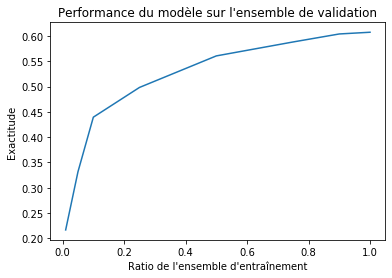

In [25]:
ratio_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
performance_study(ratio_list, epochs=5)


La tendance de la courbe suggère que plus les données sont nombreuses, plus les performances sont bonnes.

Bien que cette observation puisse être vraie en pratique, nous devons reconnaître que l'étude réalisée dans ce tutoriel repose sur certaines simplifications :

- Le nombre d'époques est fixe, quelle que soit la taille de l'ensemble de données d'entraînement. En pratique, le nombre d'époques devrait varier en fonction de l'ensemble de données dont on dispose et de la capacité du réseau.
- Aucun arrêt précoce n'est effectué.
- Aucun réglage d'hyperparamètres n'est appliqué.


Les paramètres des réseaux de neurones sont initialisés à des valeurs aléatoires. Si nous ne fixons pas une graine de modèle, les nombres aléatoires générés utilisés pour initialiser ces paramètres seront différents. Essayez de faire la même expérience avec une graine différente (par exemple, `graine=8761`) en utilisant le même nombre d'époques que dans l'exercice précédent. Obtenez-vous le même résultat ?

Meilleure exactitude: 63%


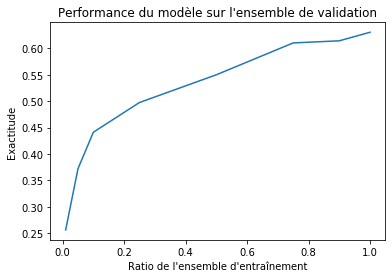

In [26]:
performance_study(ratio_list, epochs=5, seed=8761)


## Augmentation des données

Très souvent, on nous fournit un ensemble de données et il n'y a pas moyen d'en collecter davantage. Dans cette section, nous explorons rapidement la technique d'augmentation des données, qui consiste à modifier les images dans le jeu de données d'entraînement sans changer les étiquettes associées. Ce faisant, il est possible d'augmenter artificiellement le nombre d'images dans notre ensemble de données d'entraînement. Par exemple, nous pouvons penser aux opérations de renversement ou de recadrage/redimensionnement pour modifier une image dans l'ensemble de données sans modifier l'étiquette qui lui est associée. Par conséquent, en apprenant sur un plus grand nombre d'images, nous pouvons observer certains gains de performance et/ou une meilleure généralisation du modèle. Cependant, comme l'augmentation des données crée artificiellement de nouveaux exemples à partir de ceux qui existent déjà, l'hypothèse d'indépendance n'est pas respectée. Ainsi, nous ne devrions pas utiliser l'augmentation des données pour les ensemble de données de validation et d'évaluation.

### Exercice

Supposons que nous n'ayons accès qu'à 30 % de l'ensemble des données d'entraînement d'origine. Entraînez un modèle avec cette portion de données et évaluez-le sur l'ensemble de données de validation. À mesure que le nombre d'exemples augmente dans l'ensemble d'entraînement, nous pouvons envisager d'augmenter le nombre d'époques tout en gardant à l'esprit le problème du surapprentissage. Pour cet exercice, nous utiliserons les arguments suivants :
- **epochs**: `15`.
- **batch_size**: `32`.
- **metrics**: `{'Exactitude': accuracy}`.

[Époque 1/15] Perte d'entraînement: 1.868 | Perte de validation: 1.709
[Époque 2/15] Perte d'entraînement: 1.550 | Perte de validation: 1.519
[Époque 3/15] Perte d'entraînement: 1.415 | Perte de validation: 1.411
[Époque 4/15] Perte d'entraînement: 1.335 | Perte de validation: 1.411
[Époque 5/15] Perte d'entraînement: 1.256 | Perte de validation: 1.348
[Époque 6/15] Perte d'entraînement: 1.187 | Perte de validation: 1.312
[Époque 7/15] Perte d'entraînement: 1.120 | Perte de validation: 1.346
[Époque 8/15] Perte d'entraînement: 1.048 | Perte de validation: 1.345
[Époque 9/15] Perte d'entraînement: 0.998 | Perte de validation: 1.337
[Époque 10/15] Perte d'entraînement: 0.932 | Perte de validation: 1.338
[Époque 11/15] Perte d'entraînement: 0.871 | Perte de validation: 1.414
[Époque 12/15] Perte d'entraînement: 0.817 | Perte de validation: 1.447
[Époque 13/15] Perte d'entraînement: 0.755 | Perte de validation: 1.508
[Époque 14/15] Perte d'entraînement: 0.704 | Perte de validation: 1.579
[

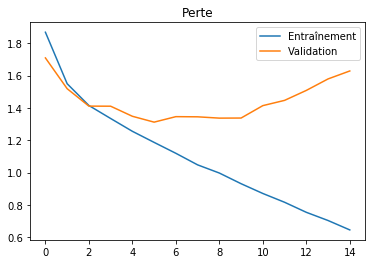

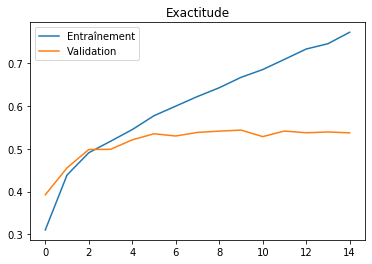

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 54%
Exactitude de plane (0): 49%
Exactitude de car   (1): 70%
Exactitude de bird  (2): 49%
Exactitude de cat   (3): 44%
Exactitude de deer  (4): 36%
Exactitude de dog   (5): 43%
Exactitude de frog  (6): 59%
Exactitude de horse (7): 54%
Exactitude de ship  (8): 73%
Exactitude de truck (9): 57%


In [27]:
# sélectionnez les données
select_imgs, select_labels = select_subset_from_dataset(train_imgs, train_labels, 0.3)

# Entraînez sur les données sélectionnées
model50 = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=15, batch_size=32, metrics={'Exactitude': accuracy})

# Évaluez sur l'ensemble de données de validation
_ = evaluate_classes(model50, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude': accuracy})

### Exercice

Le code suivant définit une transformation, en utilisant le cadre PyTorch. Avec l'opération de recadrage aléatoire, un recadrage de taille aléatoire (0,7 à 1,0) de l'image originale est effectué et celle-ci est redimensionnée en une image 32 x 32. Les opérations de "transformation" sont appliquées aux images originales à chaque génération de mini lots. Cela laisse les images de votre ensemble de données inchangées, seules les images des mini lots sont copiées et transformées à chaque itération.

In [28]:
import torchvision.transforms as transforms


transformations = transforms.Compose([
    transforms.Normalize((-1., -1., -1.), (2., 2., 2.)),
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((32, 32), scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Cette fois, entraînez un nouveau modèle en utilisant la même architecture en appliquant une augmentation des données sur les 30% extraits de l'ensemble de données d'entraînement. Évaluez votre modèle et comparez vos résultats avec ceux de l'exercice précédent. Utilisez les arguments suivants :
- **epochs**: `15`.
- **batch_size**: `32`.
- **metrics**: `{'Exactitude': accuracy}`.

Notez que vous pouvez utiliser l'argument `transformations` de la méthode `training_on_dataset` pour effectuer une augmentation des données pendant l'entraînement.

Qu'observez-vous ?

[Époque 1/15] Perte d'entraînement: 1.934 | Perte de validation: 1.862
[Époque 2/15] Perte d'entraînement: 1.697 | Perte de validation: 1.622
[Époque 3/15] Perte d'entraînement: 1.575 | Perte de validation: 1.500
[Époque 4/15] Perte d'entraînement: 1.513 | Perte de validation: 1.451
[Époque 5/15] Perte d'entraînement: 1.458 | Perte de validation: 1.467
[Époque 6/15] Perte d'entraînement: 1.408 | Perte de validation: 1.390
[Époque 7/15] Perte d'entraînement: 1.381 | Perte de validation: 1.420
[Époque 8/15] Perte d'entraînement: 1.342 | Perte de validation: 1.351
[Époque 9/15] Perte d'entraînement: 1.318 | Perte de validation: 1.342
[Époque 10/15] Perte d'entraînement: 1.296 | Perte de validation: 1.303
[Époque 11/15] Perte d'entraînement: 1.259 | Perte de validation: 1.290
[Époque 12/15] Perte d'entraînement: 1.234 | Perte de validation: 1.321
[Époque 13/15] Perte d'entraînement: 1.211 | Perte de validation: 1.276
[Époque 14/15] Perte d'entraînement: 1.194 | Perte de validation: 1.275
[

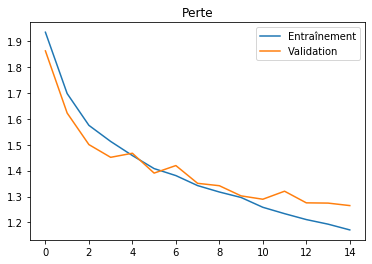

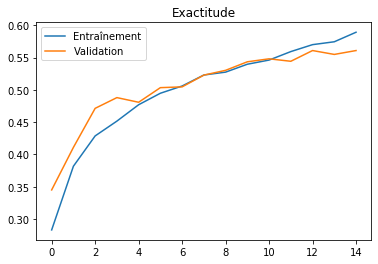

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 56%
Exactitude de plane (0): 52%
Exactitude de car   (1): 67%
Exactitude de bird  (2): 44%
Exactitude de cat   (3): 34%
Exactitude de deer  (4): 37%
Exactitude de dog   (5): 43%
Exactitude de frog  (6): 74%
Exactitude de horse (7): 62%
Exactitude de ship  (8): 74%
Exactitude de truck (9): 70%


In [29]:
# Entraînement sur les données sélectionnées avec augmentation de données
model50A = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels,  epochs=15, batch_size=32, transformations=transformations, metrics={'Exactitude': accuracy})

# Évaluez sur l'ensemble de données de validation
_ = evaluate_classes(model50A, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude': accuracy})

Nous observons que la performance sur l'ensemble des données de validation après 15 époques est supérieure à celle obtenue lors de l'exercice précédent. Il est intéressant de noter que le phénomène de surapprentissage observé précédemment n'est plus présent. C'est la preuve que l'entraînement d'un modèle sur un ensemble de données plus diversifié qui a été augmenté par des transformations d'images aide à réduire le surapprentissage.


# Ensembles de données non équilibrés

## Qu'est-ce qu'un ensemble de données déséquilibré ?

Jusqu'à présent, l'ensemble des données d'entraînement contenait à peu près le même nombre d'images pour chaque étiquette. Dans cette section, nous examinons l'impact d'entraîner des modèles sur un ensemble de données déséquilibré, ce qui se produit lorsque chaque classe ne constitue pas une portion égale de votre ensemble de données. 

La fonction suivante sélectionne une partie des données d'un ensemble de données donné tout en fournissant une distribution d'étiquettes définie. Elle prend en entrée six arguments :
- **imgs** : tableau numpy représentant l'ensemble d'images à partir duquel la sélection est effectuée.
- **labels** : étiquettes associées à l'ensemble d'images fourni.
- **label_dist** : la distribution des étiquettes à sélectionner, représentée par un dict de `{label : value}`.
- **ratio** (facultatif) : partie des données qui seront sélectionnées. Valeur par défaut : `0.1`.
- **shuffle** ( facultatif ) : si les données doivent être mélangées ou non avant que la sélection ne soit effectuée. Valeur par défaut : `True`.
- **seed** ( facultatif ) : graine du générateur aléatoire : Valeur par défaut : `1234`.

Elle fournit en sortie 2 éléments :
- **select_imgs** : un tableau numpy des images sélectionnées.
- **select_labels** : étiquettes associées aux images sélectionnées.


In [30]:
def select_subset_from_dataset_with_label_dist(
    imgs, labels, label_dist, ratio=0.1, shuffle=True, seed=1234):
  """
  Args :
     imgs : tableau numpy représentant l'ensemble d'images à partir duquel 
        la sélection est faite.
     labels : les étiquettes associées aux images fournies.
     label_dist : la distribution des étiquettes à sélectionner.
     ratio ( facultatif ) : partie des données à sélectionner. Par défaut : 0.1.
     shuffle ( facultatif) : Permet de mélanger ou non les données. 
         Par défaut : True.
     seed ( facultatif ) : graine du générateur aléatoire numpy : 
         Par défaut : 1234.
        
  Return (retour) :
     Un tuple de 2 éléments (select_imgs, select_labels)
     où :
        select_imgs : un tableau numpy des images sélectionnées.
        select_labels : étiquettes associées aux images sélectionnées.
      
  """
  if isinstance(label_dist, (list, tuple)):
    label_dist = {a:v for a,v in enumerate(label_dist)}
  sum_dist = sum(label_dist.values())
  for lab in label_dist.keys():
    label_dist[lab] /= sum_dist
    
  tgts = np.array(labels)
  num_indices = int(ratio*len(labels))
  num_idx_lab = {a: int(label_dist[a]*num_indices) for a in label_dist.keys()}
  
  sel_ind = []
  
  if shuffle:
    np.random.seed(seed)  # Fixez la graine aléatoire de numpy.

  for a in num_idx_lab.keys():
    idx = np.where(tgts==a)
    idx = idx[0]
    if shuffle:
      idx = np.random.permutation(idx)
    num = min(num_idx_lab[a], len(idx))
    idx = idx[0:num]
    sel_ind.extend(idx)
    
  if shuffle:
    sel_ind = np.random.permutation(sel_ind)
  else:
    sel_ind.sort()
    sel_ind = np.array(sel_ind)
    
  select_imgs = imgs[sel_ind, :]
  select_labels = tgts[sel_ind].tolist()
  
  return select_imgs, select_labels


### Exercise

En utilisant la fonction définie ci-dessus avec ses paramètres par défaut, extraire 30 % des données de l'ensemble de données d'entraînement original tout en fournissant la distribution d'étiquettes suivante :
- **0**: `0.4`.
- **1**: `0.1`.
- **2**: `0.05`.
- **3**: `0.01`.
- **4**: `0.2`.
- **5**: `0.14`.
- **6**: `0.02`.
- **7**: `0.005`.
- **8**: `0.045`.
- **9**: `0.03`.

De plus, calculez l'histogramme de l'ensemble de données résultant.

Notez que nous allons d'abord entraîner notre modèle sur un ensemble de données d'entraînement non équilibré, mais évaluez-le sur l'ensemble de validation équilibré que nous utilisons depuis le début de ce tutoriel. Nous construirons ensuite un ensemble de validation avec une distribution qui correspond à celle de l'ensemble d'entraînement.


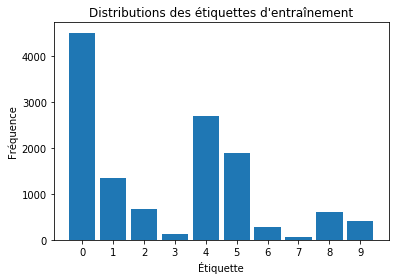

In [31]:
label_distribution = {
    0: 0.4,
    1: 0.1,
    2: 0.05,
    3: 0.01,
    4: 0.2, 
    5: 0.14,
    6: 0.02,
    7: 0.005,
    8: 0.045,
    9: 0.03
}

# choisissez les données selon la distribution donnée
select_imgs, select_labels = select_subset_from_dataset_with_label_dist(train_imgs, train_labels, label_distribution, 0.3)

# tracer l'histogramme des étiquettes correspondantes
plot_dataset_histogram(select_labels, "Distributions des étiquettes d'entraînement")


## L'exactitude est-elle une bonne mesure pour un ensemble de données déséquilibré ?

### Exercice

Entraînez un modèle en utilisant votre nouvel ensemble de données d'entraînement extraites et évaluez sa performance sur l'ensemble de données de validation. Utilisez les arguments suivants :
- **epochs** : `15`.
- **batch_size** : `32`.
- **metrics** : `{'Exactitude': accuracy} `.

Qu'observez-vous en termes de différences entre l'exactitude d'entraînement et l'exactitude de validation? Qu'observez-vous en ce qui concerne l'exactitude des étiquettes moins fréquentes ?


[Époque 1/15] Perte d'entraînement: 1.469 | Perte de validation: 2.275
[Époque 2/15] Perte d'entraînement: 1.190 | Perte de validation: 2.282
[Époque 3/15] Perte d'entraînement: 1.091 | Perte de validation: 2.130
[Époque 4/15] Perte d'entraînement: 1.026 | Perte de validation: 2.057
[Époque 5/15] Perte d'entraînement: 0.981 | Perte de validation: 2.160
[Époque 6/15] Perte d'entraînement: 0.923 | Perte de validation: 2.117
[Époque 7/15] Perte d'entraînement: 0.878 | Perte de validation: 2.160
[Époque 8/15] Perte d'entraînement: 0.836 | Perte de validation: 1.960
[Époque 9/15] Perte d'entraînement: 0.783 | Perte de validation: 2.074
[Époque 10/15] Perte d'entraînement: 0.747 | Perte de validation: 1.973
[Époque 11/15] Perte d'entraînement: 0.699 | Perte de validation: 1.935
[Époque 12/15] Perte d'entraînement: 0.651 | Perte de validation: 1.907
[Époque 13/15] Perte d'entraînement: 0.606 | Perte de validation: 2.152
[Époque 14/15] Perte d'entraînement: 0.564 | Perte de validation: 2.015
[

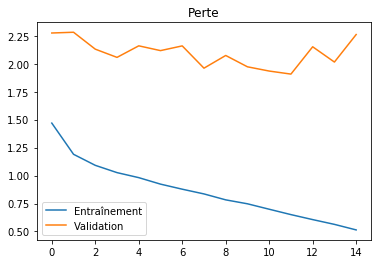

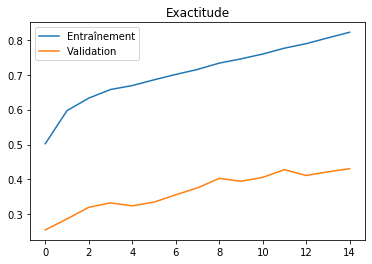

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 43%
Exactitude de plane (0): 84%
Exactitude de car   (1): 75%
Exactitude de bird  (2): 20%
Exactitude de cat   (3): 0%
Exactitude de deer  (4): 71%
Exactitude de dog   (5): 65%
Exactitude de frog  (6): 28%
Exactitude de horse (7): 4%
Exactitude de ship  (8): 51%
Exactitude de truck (9): 31%


In [35]:
# Entraînement sur les données sélectionnées
modelUnbal = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=15, batch_size=32, metrics={'Exactitude': accuracy})

# Évaluation sur l'ensemble de données de validation
_ = evaluate_classes(modelUnbal, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude': accuracy})

Comme les classes `cat (3)` et `cheval (7)` ont très peu d'exemples dans l'ensemble extrait des données d'entraînement, la performance de ces classes est extrêmement faible. Cela est dû au fait qu'un petit nombre d'exemples de ces classes ont été vus pendant le processus d'entraînement. De plus, nous observons un grand écart de performance entre l'ensemble des données d'entraînement et l'ensemble des données de validation.


### Exercice
Lorsque nous disposons d'un ensemble de données déséquilibré, le score F1 est généralement une mesure de performance recommandée car il peut être interprété comme une moyenne pondérée des [scores de précision et de rappel](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel).

Entraînez un modèle en utilisant l'ensemble de données d'entraînement extraites et évaluez ses performances sur l'ensemble de données de validation. Utilisez les mêmes arguments que pour le dernier exercice, mais ajoutez le score F1 :
- **epochs** : `15`.
- **batch_size** : `32`.
- **metrics** : `{'Exactitude': accuracy, 'F1' : f1_score}`.

Quelles différences observez-vous en termes de mesure des performances entre les ensembles de données d'entraînement et de validation ?

[Époque 1/15] Perte d'entraînement: 1.469 | Perte de validation: 2.275
[Époque 2/15] Perte d'entraînement: 1.190 | Perte de validation: 2.282
[Époque 3/15] Perte d'entraînement: 1.091 | Perte de validation: 2.130
[Époque 4/15] Perte d'entraînement: 1.026 | Perte de validation: 2.057
[Époque 5/15] Perte d'entraînement: 0.981 | Perte de validation: 2.160
[Époque 6/15] Perte d'entraînement: 0.923 | Perte de validation: 2.117
[Époque 7/15] Perte d'entraînement: 0.878 | Perte de validation: 2.160
[Époque 8/15] Perte d'entraînement: 0.836 | Perte de validation: 1.960
[Époque 9/15] Perte d'entraînement: 0.783 | Perte de validation: 2.074
[Époque 10/15] Perte d'entraînement: 0.747 | Perte de validation: 1.973
[Époque 11/15] Perte d'entraînement: 0.699 | Perte de validation: 1.935
[Époque 12/15] Perte d'entraînement: 0.651 | Perte de validation: 1.907
[Époque 13/15] Perte d'entraînement: 0.606 | Perte de validation: 2.152
[Époque 14/15] Perte d'entraînement: 0.564 | Perte de validation: 2.015
[

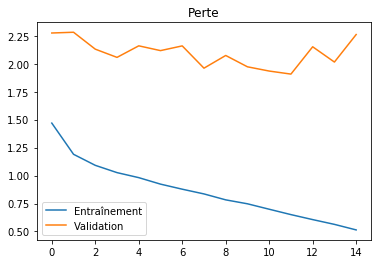

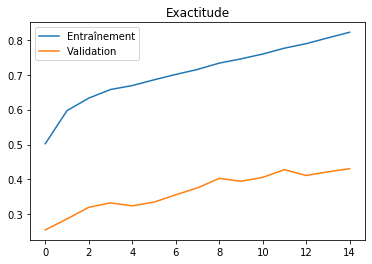

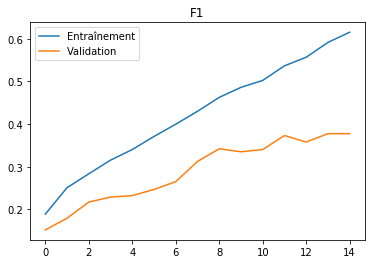

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 43%
Mesure F1: 38%
Exactitude de plane (0): 84%
Exactitude de car   (1): 75%
Exactitude de bird  (2): 20%
Exactitude de cat   (3): 0%
Exactitude de deer  (4): 71%
Exactitude de dog   (5): 65%
Exactitude de frog  (6): 28%
Exactitude de horse (7): 4%
Exactitude de ship  (8): 51%
Exactitude de truck (9): 31%


In [34]:
# Entraînement sur les données sélectionnées
modelUnbal = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=15, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score})

# Évaluation sur l'ensemble de données de validation
_ = evaluate_classes(modelUnbal, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score})


Nous observons les conséquences de l'entraînement d'un modèle sur un ensemble de données non équilibré sur les mesures de performance évaluées sur l'ensemble de validation. Pour comparer avec la section précédente, nous utilisons le même ensemble de validation (qui est équilibré).
Pour un modèle entraîné avec 15 époques, nous obtenons un écart entre l'exactitude et le score F1. Cet écart montre comment l'exactitude accorde moins d'importance aux classes sous-représentées. Ainsi, en général, l'exactitude ne convient pas pour évaluer un modèle sur un ensemble de données non équilibré (voir [ici](https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_Data) pour plus de détails). Par exemple, imaginez un scénario de classification binaire où 0 est la classe négative et 1 est la classe positive. Si 95% de vos exemples d'entraînement appartiennent à la classe négative, alors un classificateur qui prédit toujours 0 aura une exactitude de 95%. Cependant, en raison de son faible score de rappel, il aura un faible score F1. 

Notez que dans cette expérience, l'ensemble de données de validation n'a pas la même distribution que l'ensemble de données d'entraînement. Cette situation se produit souvent dans des scénarios de la vie réelle. Lorsqu'il n'est pas possible d'avoir des ensembles d'entraînement/validation/évaluation avec des distributions similaires, il faut au moins essayer de s'assurer que les distributions de l'ensemble de validation et de l'ensemble d'évaluation correspondent autant que possible.



### Exercice
Imaginez maintenant que l'ensemble de validation soit aussi déséquilibré que l'ensemble d'entraînement. L'observation faite précédemment est-elle toujours valable ?

Pour répondre à cette question, extrayez 30 % de l'ensemble de données de validation original avec la distribution d'étiquettes ci-dessus et utilisez-le comme nouvel ensemble de validation pour cet exercice.

[Époque 1/15] Perte d'entraînement: 1.469 | Perte de validation: 1.259
[Époque 2/15] Perte d'entraînement: 1.190 | Perte de validation: 1.135
[Époque 3/15] Perte d'entraînement: 1.091 | Perte de validation: 1.053
[Époque 4/15] Perte d'entraînement: 1.026 | Perte de validation: 1.047
[Époque 5/15] Perte d'entraînement: 0.981 | Perte de validation: 1.015
[Époque 6/15] Perte d'entraînement: 0.923 | Perte de validation: 1.003
[Époque 7/15] Perte d'entraînement: 0.878 | Perte de validation: 0.975
[Époque 8/15] Perte d'entraînement: 0.836 | Perte de validation: 0.936
[Époque 9/15] Perte d'entraînement: 0.783 | Perte de validation: 1.028
[Époque 10/15] Perte d'entraînement: 0.747 | Perte de validation: 0.942
[Époque 11/15] Perte d'entraînement: 0.699 | Perte de validation: 0.939
[Époque 12/15] Perte d'entraînement: 0.651 | Perte de validation: 0.958
[Époque 13/15] Perte d'entraînement: 0.606 | Perte de validation: 0.968
[Époque 14/15] Perte d'entraînement: 0.564 | Perte de validation: 0.979
[

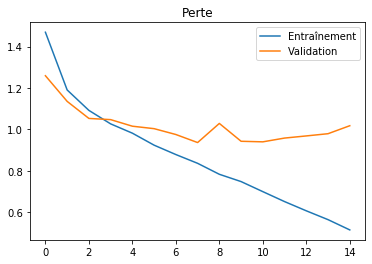

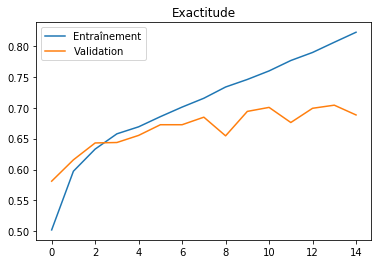

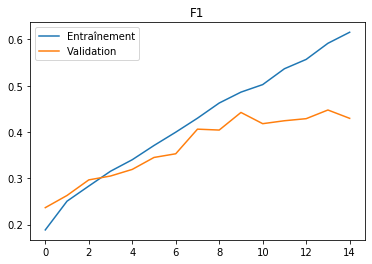

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 69%
Mesure F1: 43%
Exactitude de plane (0): 84%
Exactitude de car   (1): 77%
Exactitude de bird  (2): 17%
Exactitude de cat   (3): 0%
Exactitude de deer  (4): 72%
Exactitude de dog   (5): 68%
Exactitude de frog  (6): 33%
Exactitude de horse (7): 0%
Exactitude de ship  (8): 46%
Exactitude de truck (9): 31%


In [37]:
# sélectionner 30 % de l'ensemble de validation avec la distribution fournie
# des étiquettes
unb_valid_imgs, unb_valid_labels = select_subset_from_dataset_with_label_dist(valid_imgs, valid_labels, label_distribution, 0.3)


# entraînement avec des ensembles d'entraînement et de validation non équilibrés
modelUnbal = training_on_dataset(select_imgs, select_labels, unb_valid_imgs, unb_valid_labels, epochs=15, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score})

# Évaluer sur l'ensemble de validation non-équilibré
_ = evaluate_classes(modelUnbal, unb_valid_imgs, unb_valid_labels, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score})


Nous observons que la mesure d'exactitude sur l'ensemble de données non équilibrées est plus élevée par rapport à l'expérience précédente. C'est un comportement prévu car (1) l'ensemble de données de validation partage la même distribution que l'ensemble de données d'entraînement et (2) la mesure d'exactitude traite chaque exemple de manière égale sans tenir compte de la fréquence de sa classe dans l'ensemble de données.

Il y a également une amélioration de la métrique F1 sur l'ensemble de validation non équilibré. Cependant, nous observons toujours de mauvaises performances pour les classes moins fréquentes.

Enfin, l'écart entre les deux métriques est plus grand par rapport à l'expérience précédente.



## Gestion des ensembles de données déséquilibrés

Une façon d'atténuer l'effet d'un ensemble de données déséquilibré pendant le processus d'entraînement est de pénaliser le modèle lorsqu'il fait des erreurs de classification sur des classes moins fréquentes. Un moyen d'y parvenir est d'attribuer des poids d'importance aux étiquettes qui sont inversement proportionnels à leur densité dans l'ensemble de données.

### Exercice

Calculez les poids d'importance de chaque étiquette en utilisant la distribution des étiquettes fournie à la section précédente.


In [38]:
label_weights = [1.0/label_distribution[a] for a in range(10)]

for i, w in enumerate(label_weights):
  print("Poids d'importance pour {:<5s} ({}): {:.1f}".format(classe_names[i], i, w))

Poids d'importance pour plane (0): 2.5
Poids d'importance pour car   (1): 10.0
Poids d'importance pour bird  (2): 20.0
Poids d'importance pour cat   (3): 100.0
Poids d'importance pour deer  (4): 5.0
Poids d'importance pour dog   (5): 7.1
Poids d'importance pour frog  (6): 50.0
Poids d'importance pour horse (7): 200.0
Poids d'importance pour ship  (8): 22.2
Poids d'importance pour truck (9): 33.3


### Exercice

En utilisant les poids d'importance calculés ci-dessus, entraînez un modèle en utilisant l'ensemble de données d'entraînement extraites et évaluez sa performance sur l'ensemble de données de validation d'origine. Afin d'obtenir des comparaisons équitables, utilisez les mêmes arguments que dans l'exercice précédent :
- **epochs** : `15`.
- **batch_size** : `32`.
- **metrics** : `{'Exactitude': accuracy, 'F1': f1_score}`.

Notez que les poids d'importance peuvent être transmis à la méthode d'entraînement en utilisant l'argument `label_weights`.

Qu'observez-vous ?


[Époque 1/15] Perte d'entraînement: 1.984 | Perte de validation: 2.165
[Époque 2/15] Perte d'entraînement: 1.718 | Perte de validation: 2.067
[Époque 3/15] Perte d'entraînement: 1.577 | Perte de validation: 1.853
[Époque 4/15] Perte d'entraînement: 1.483 | Perte de validation: 1.747
[Époque 5/15] Perte d'entraînement: 1.392 | Perte de validation: 2.024
[Époque 6/15] Perte d'entraînement: 1.298 | Perte de validation: 2.083
[Époque 7/15] Perte d'entraînement: 1.202 | Perte de validation: 1.919
[Époque 8/15] Perte d'entraînement: 1.130 | Perte de validation: 2.148
[Époque 9/15] Perte d'entraînement: 1.034 | Perte de validation: 2.903
[Époque 10/15] Perte d'entraînement: 0.949 | Perte de validation: 3.215
[Époque 11/15] Perte d'entraînement: 0.869 | Perte de validation: 3.431
[Époque 12/15] Perte d'entraînement: 0.794 | Perte de validation: 3.741
[Époque 13/15] Perte d'entraînement: 0.720 | Perte de validation: 4.812
[Époque 14/15] Perte d'entraînement: 0.666 | Perte de validation: 4.631
[

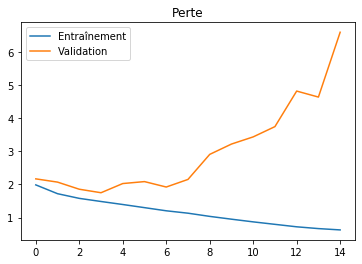

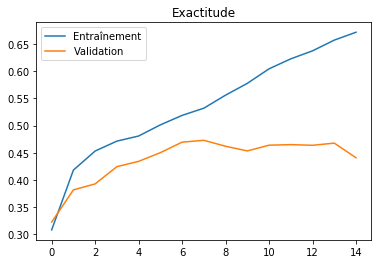

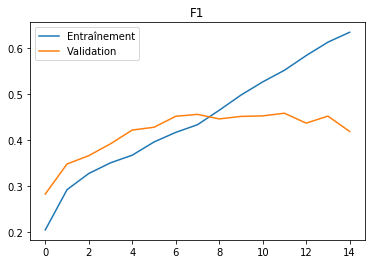

Évaluation sur l'ensemble des données de validation: 
Mesure Exactitude: 44%
Mesure F1: 42%
Exactitude de plane (0): 63%
Exactitude de car   (1): 61%
Exactitude de bird  (2): 33%
Exactitude de cat   (3): 8%
Exactitude de deer  (4): 65%
Exactitude de dog   (5): 58%
Exactitude de frog  (6): 37%
Exactitude de horse (7): 11%
Exactitude de ship  (8): 62%
Exactitude de truck (9): 42%


In [40]:
# Entraînement sur les données sélectionnées
modelUnbal2 = training_on_dataset(select_imgs, select_labels, valid_imgs, valid_labels, epochs=15, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score}, label_weights=label_weights)

# Évaluation sur l'ensemble de données de validation
_ = evaluate_classes(modelUnbal2, valid_imgs, valid_labels, batch_size=32, metrics={'Exactitude':accuracy, 'F1':f1_score})

Après avoir entraîné notre modèle avec des poids d'importance, nous constatons que le score F1 est significativement plus élevé que celui obtenu sans les poids d'importance. De plus, l'utilisation des poids d'importance entraîne un gain d'exactitude notable pour les classes moins fréquentes, telles que le chat (3) et le cheval (7), qui ont obtenu une exactitude proche de 0 % dans l'exemple précédent.


# Reproductibilité

Nous avons vu qu'il y a place pour beaucoup de hasard dans les expériences d'apprentissage automatique, en particulier durant:
- la division d'un ensemble de données original en ensembles d'entraînement/validation/évaluation.
- l'initialisation des paramètres d'un modèle.
- la division d'un ensemble d'entraînement en lots pour entraîner un modèle.

Par conséquent, nous obtenons normalement des résultats différents chaque fois que nous menons la même expérience. Pour permettre la reproductibilité de vos résultats, il est nécessaire de fixer la **graine aléatoire** avant de créer chaque ensemble de données et chaque modèle. Par conséquent, pour être reproductible, il est préférable de fixer manuellement les éléments suivants:

1. Générateur de nombres pseudo-aléatoires en python à une valeur fixe :
```
import random
random.seed(seed_value)
```

2. Générateur de nombres pseudo-aléatoires NumPy à une valeur fixe :
```
import numpy as np
np.random.seed(seed_value)
```

3. Générateur de nombres pseudo-aléatoires PyTorch à une valeur fixe pour tous les appareils (CPU et GPU) :
```
import torch
torch.manual_seed(seed_value)
```

4. Générateur de nombres pseudo-aléatoires PyTorch à une valeur fixe pour le(s) GPU :
```
import torch
torch.cuda.manual_seed(seed_value)  # Current GPU.
torch.cuda.manual_seed_all(seed_value)  # All GPUs.
```

5. Algorithmes CuDNN (une extension de CUDA pour l'apprentissage profond) pour être déterministe dans PyTorch:
```
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
```

Notez que les algorithmes déterministes peuvent rendre les calculs considérablement plus lents. Bien que la fixation manuelle des graines aléatoires aide à la reproductibilité, des résultats complètement reproductibles ne sont pas garantis pour toutes les versions de PyTorch et les différentes plateformes, dispositifs ou pilotes (*drivers*).

De plus, il y a plus de hasard lors du réglage des hyperparamètres ou de l'utilisation de plusieurs GPU en parallèle, mais cela dépasse la portée de ce tutoriel.

Enfin, une bonne pratique, mise en œuvre dans Scikit-Learn, consiste à créer un objet RandomState local au lieu d'utiliser l'objet RandomState global et de le passer à chaque module en utilisant le caractère aléatoire. Cependant, l'API Pytorch ne le permet pas, et pour l'instant, il est recommandé d'utiliser des générateur de nombres pseudo-aléatoires globaux.
